In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report, ConfusionMatrixDisplay,roc_curve, roc_auc_score, RocCurveDisplay, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("BMW_Car_Sales_Classification.csv")
%matplotlib inline


Saving BMW_Car_Sales_Classification.csv to BMW_Car_Sales_Classification.csv


Importing Libraries

In [2]:
df['Sales_Classification'].value_counts()

,count
Sales_Classification,
Low,34754
High,15246


Sales_Classification
Low     34754
High    15246
Name: count, dtype: int64


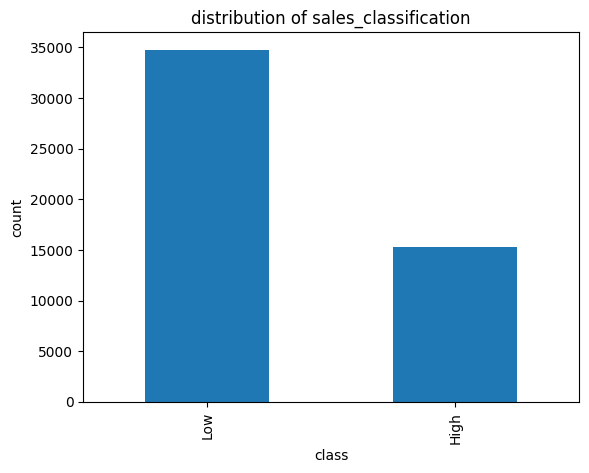

In [3]:
target = 'Sales_Classification'
counts = df[target].value_counts()
print(counts)

plt.figure()
counts.plot(kind='bar')
plt.title('distribution of sales_classification')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

class low has 70% of target column
class high has 30% of target column

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


check data info and we have 6 columns to transform

In [5]:
df.shape

(50000, 11)

In [6]:
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


seeing sampels from data

In [7]:
df['Model'].unique()

array(['5 Series', 'i8', 'X3', '7 Series', 'M5', '3 Series', 'X1', 'M3',
       'X5', 'i3', 'X6'], dtype=object)

In [8]:
df['Region'].unique()

array(['Asia', 'North America', 'Middle East', 'South America', 'Europe',
       'Africa'], dtype=object)

In [9]:
df['Color'].unique()

array(['Red', 'Blue', 'Black', 'Silver', 'White', 'Grey'], dtype=object)

In [10]:
df['Fuel_Type'].unique()

array(['Petrol', 'Hybrid', 'Diesel', 'Electric'], dtype=object)

check count unique values to know method we need for transforming

In [11]:
df.isna().sum()

,0
Model,0
Year,0
Region,0
Color,0
Fuel_Type,0
Transmission,0
Engine_Size_L,0
Mileage_KM,0
Price_USD,0
Sales_Volume,0


check missing values : no missing values

In [12]:
def count_outliers_per_column(df):
    outlier_counts = {}
    total_outliers = 0

    numeric_cols = df.select_dtypes(include='number').columns

    for column in numeric_cols:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        count = outliers.shape[0]

        outlier_counts[column] = count
        total_outliers += count

    return outlier_counts, total_outliers

outliers_dict, total = count_outliers_per_column(df)


print("outliers in all columns")
for col, count in outliers_dict.items():
    print(f"{col}: {count}")

print(f"\n total outliers = {total}")

outliers in all columns
Year: 0
Engine_Size_L: 0
Mileage_KM: 0
Price_USD: 0
Sales_Volume: 0

 total outliers = 0


check outliers by iqr method : no outliers

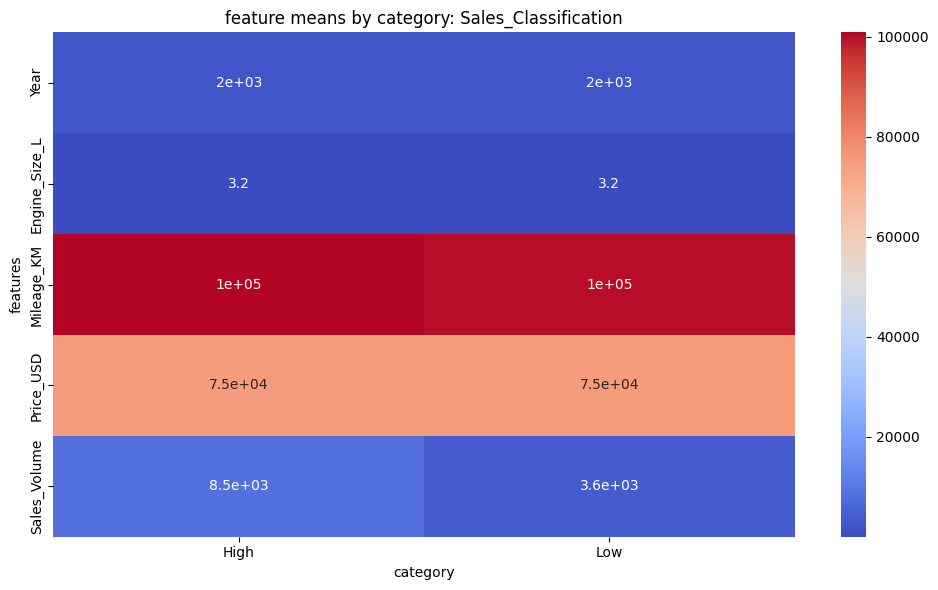

In [13]:
target_col = 'Sales_Classification'

grouped = df.groupby(target_col).mean(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(grouped.T, annot=True, cmap='coolwarm')
plt.title(f'feature means by category: {target_col}')
plt.ylabel('features')
plt.xlabel('category')
plt.tight_layout()
plt.show()

we applied groupby to calculate the mean of each numerical feature for each category in our target column then we plotted a heatmap and it was clear that there is a strong correlation between the sales volume column and the target while the other features had a weaker impac

preprocessing steps
we applied preprocessing on x train and used the same transformations on x test to avoid data leakage

In [14]:
X = df.drop('Sales_Classification', axis=1)
y = df['Sales_Classification']

set x (features),set y (target )

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

we used stratified split to maintain the distribution ratio in our target variable

In [16]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

we used label encoding on the target column because there was a pattern in the labels

In [17]:
scaled_cols = ['Mileage_KM','Price_USD','Sales_Volume']
categorical_cols = ['Fuel_Type','Color','Region','Model','Transmission']

In [18]:
preprocessor= ColumnTransformer([
    ('minmax', MinMaxScaler(), scaled_cols),
    ('onehot', OneHotEncoder(sparse_output = False,handle_unknown='ignore')
, categorical_cols)
])

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

uesing min_max and one hot for transform columns
 sparse\_output false means the output will be a regular dense array
 handle\_unknown ignore allows the encoder to skip unknown categories without crashing
 we performed the preprocessing using columntransformer to organize the steps inside it and to include it later in the pipeline

In [19]:
ohe = preprocessor.named_transformers_['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = scaled_cols + list(ohe_feature_names)

x_train_processed_df = pd.DataFrame(x_train_processed, columns=all_feature_names)
x_train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Mileage_KM              40000 non-null  float64
 1   Price_USD               40000 non-null  float64
 2   Sales_Volume            40000 non-null  float64
 3   Fuel_Type_Diesel        40000 non-null  float64
 4   Fuel_Type_Electric      40000 non-null  float64
 5   Fuel_Type_Hybrid        40000 non-null  float64
 6   Fuel_Type_Petrol        40000 non-null  float64
 7   Color_Black             40000 non-null  float64
 8   Color_Blue              40000 non-null  float64
 9   Color_Grey              40000 non-null  float64
 10  Color_Red               40000 non-null  float64
 11  Color_Silver            40000 non-null  float64
 12  Color_White             40000 non-null  float64
 13  Region_Africa           40000 non-null  float64
 14  Region_Asia             40000 non-null

In [20]:
pd.Series(y_test_encoded).value_counts(normalize=True) * 100

,proportion
1,69.51
0,30.49


In [33]:
def evaluate_models(x_train_processed, y_train_encoded, x_test_processed, y_test_encoded):
    models = {'svm': SVC(),'naive bayes': GaussianNB(),'random forest': RandomForestClassifier(),'XGBoost': XGBClassifier(),'decision dree': DecisionTreeClassifier(),'logistic regression': LogisticRegression(),
     'KNN': KNeighborsClassifier(),'ex_trees':ExtraTreesClassifier(),'bagging':BaggingClassifier() }

    for name, model in models.items():

        print(f"Model: {name}")
        model.fit(x_train_processed, y_train_encoded)
        y_train_pred = model.predict(x_train_processed)
        y_test_pred = model.predict(x_test_processed)

        train_acc = accuracy_score(y_train_encoded, y_train_pred)
        train_prec = precision_score(y_train_encoded, y_train_pred, average='weighted', zero_division=0)
        train_rec = recall_score(y_train_encoded, y_train_pred, average='weighted')
        train_f1 = f1_score(y_train_encoded, y_train_pred, average='weighted')

        test_acc = accuracy_score(y_test_encoded, y_test_pred)
        test_prec = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
        test_rec = recall_score(y_test_encoded, y_test_pred, average='weighted')
        test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

        print(f" train  accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, recall: {train_rec:.4f}, F1: {train_f1:.4f}")
        print(f" test   accuracy: {test_acc:.4f}, precision: {test_prec:.4f}, recall: {test_rec:.4f}, F1: {test_f1:.4f}\n")




evaluate_models(x_train_processed, y_train_encoded, x_test_processed, y_test_encoded)


Model: svm
 train  accuracy: 0.9944, Precision: 0.9944, recall: 0.9944, F1: 0.9944
 test   accuracy: 0.9876, precision: 0.9876, recall: 0.9876, F1: 0.9876

Model: naive bayes
 train  accuracy: 0.9955, Precision: 0.9955, recall: 0.9955, F1: 0.9955
 test   accuracy: 0.9957, precision: 0.9957, recall: 0.9957, F1: 0.9957

Model: random forest
 train  accuracy: 1.0000, Precision: 1.0000, recall: 1.0000, F1: 1.0000
 test   accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000

Model: XGBoost
 train  accuracy: 1.0000, Precision: 1.0000, recall: 1.0000, F1: 1.0000
 test   accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000

Model: decision dree
 train  accuracy: 1.0000, Precision: 1.0000, recall: 1.0000, F1: 1.0000
 test   accuracy: 1.0000, precision: 1.0000, recall: 1.0000, F1: 1.0000

Model: logistic regression
 train  accuracy: 0.9985, Precision: 0.9985, recall: 0.9985, F1: 0.9985
 test   accuracy: 0.9986, precision: 0.9986, recall: 0.9986, F1: 0.9986

Model: KNN
 trai

 performance evaluation was conducted on multiple classification models using accuracy precision recall and f1 score on both training and testing data the naive bayes logistic regression and svm models showed excellent results while the other models indicated signs of overfitting

In [34]:
c_values = [0.1, 1,4, 10]
gamma_values = [0.1, 1,2,5]
results = []

sample = 0.2
sample_size = int(len(x_train_processed) * sample)

np.random.seed(42)
indices = np.random.choice(len(x_train_processed), size=sample_size, replace=False)

x_sample = x_train_processed[indices]
y_sample = y_train_encoded[indices]

for C in c_values:
    for gamma in gamma_values:
        model = SVC(C=C, gamma=gamma, kernel='rbf',class_weight='balanced')
        model.fit(x_sample, y_sample)

        y_train_pred = model.predict(x_sample)
        train_acc = accuracy_score(y_sample, y_train_pred)
        train_prec = precision_score(y_sample, y_train_pred, average='weighted', zero_division=0)
        train_rec = recall_score(y_sample, y_train_pred, average='weighted')
        train_f1 = f1_score(y_sample, y_train_pred, average='weighted')

        y_test_pred = model.predict(x_test_processed)
        test_acc = accuracy_score(y_test_encoded, y_test_pred)
        test_prec = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
        test_rec = recall_score(y_test_encoded, y_test_pred, average='weighted')
        test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

        results.append({'C': C,'gamma': gamma,'train_acc': train_acc,'train_prec': train_prec,'train_rec': train_rec,'train_f1': train_f1,'test_acc': test_acc,'test_prec': test_prec,'test_rec': test_rec,
            'test_f1': test_f1 })

for res in results:
    print(f"c={res['C']} gamma={res['gamma']}")
    print(f"train acc={res['train_acc']:.4f} prec={res['train_prec']:.4f} rec={res['train_rec']:.4f} f1={res['train_f1']:.4f}")
    print(f"test  acc={res['test_acc']:.4f} prec={res['test_prec']:.4f} rec={res['test_rec']:.4f} f1={res['test_f1']:.4f}")
    print("")

best_model = max(results, key=lambda x: x['test_f1'])

print(f"best c={best_model['C']} gamma={best_model['gamma']}")
print(f"test acc={best_model['test_acc']:.4f} prec={best_model['test_prec']:.4f} rec={best_model['test_rec']:.4f} f1={best_model['test_f1']:.4f}")


c=0.1 gamma=0.1
train acc=0.9086 prec=0.9300 rec=0.9086 f1=0.9115
test  acc=0.9103 prec=0.9307 rec=0.9103 f1=0.9130

c=0.1 gamma=1
train acc=0.9181 prec=0.9231 rec=0.9181 f1=0.9147
test  acc=0.7862 prec=0.8116 rec=0.7862 f1=0.7500

c=0.1 gamma=2
train acc=0.7016 prec=0.7908 rec=0.7016 f1=0.5797
test  acc=0.6951 prec=0.4832 rec=0.6951 f1=0.5701

c=0.1 gamma=5
train acc=0.7005 prec=0.4907 rec=0.7005 f1=0.5771
test  acc=0.6951 prec=0.4832 rec=0.6951 f1=0.5701

c=1 gamma=0.1
train acc=0.9659 prec=0.9694 rec=0.9659 f1=0.9664
test  acc=0.9632 prec=0.9671 rec=0.9632 f1=0.9637

c=1 gamma=1
train acc=0.9683 prec=0.9713 rec=0.9683 f1=0.9687
test  acc=0.8857 prec=0.8894 rec=0.8857 f1=0.8869

c=1 gamma=2
train acc=0.9683 prec=0.9711 rec=0.9683 f1=0.9687
test  acc=0.7257 prec=0.7095 rec=0.7257 f1=0.7125

c=1 gamma=5
train acc=0.9895 prec=0.9899 rec=0.9895 f1=0.9896
test  acc=0.7346 prec=0.7188 rec=0.7346 f1=0.6944

c=4 gamma=0.1
train acc=0.9848 prec=0.9855 rec=0.9848 f1=0.9849
test  acc=0.9744 pre

different values of gamma and c were tested on the svm model using a random sample of the data to find the best values to use

In [35]:
model_1 = SVC(C=10,gamma=0.1,kernel='rbf',class_weight='balanced')
model_1.fit(x_train_processed, y_train_encoded)

y_train_pred_svm = model_1.predict(x_train_processed)
y_test_pred_svm = model_1.predict(x_test_processed)

train_acc_svm = accuracy_score(y_train_encoded, y_train_pred_svm)
train_prec_svm = precision_score(y_train_encoded, y_train_pred_svm, average='weighted', zero_division=0)
train_rec_svm = recall_score(y_train_encoded, y_train_pred_svm, average='weighted')
train_f1_svm = f1_score(y_train_encoded, y_train_pred_svm, average='weighted')

test_acc_svm = accuracy_score(y_test_encoded, y_test_pred_svm)
test_prec_svm = precision_score(y_test_encoded, y_test_pred_svm, average='weighted', zero_division=0)
test_rec_svm = recall_score(y_test_encoded, y_test_pred_svm, average='weighted')
test_f1_svm = f1_score(y_test_encoded, y_test_pred_svm, average='weighted')

print("\nsvm results:")
print(f"train -> acc={train_acc_svm:.4f} prec={train_prec_svm:.4f} rec={train_rec_svm:.4f} f1={train_f1_svm:.4f}")
print(f"test  -> acc={test_acc_svm:.4f} prec={test_prec_svm:.4f} rec={test_rec_svm:.4f} f1={test_f1_svm:.4f}")



svm results:
train -> acc=0.9934 prec=0.9935 rec=0.9934 f1=0.9934
test  -> acc=0.9891 prec=0.9893 rec=0.9891 f1=0.9891


the previously specified parameters were tested on the svm model using the linear kernel and the results showed high accuracy demonstrating the models strong ability to separate the two classe

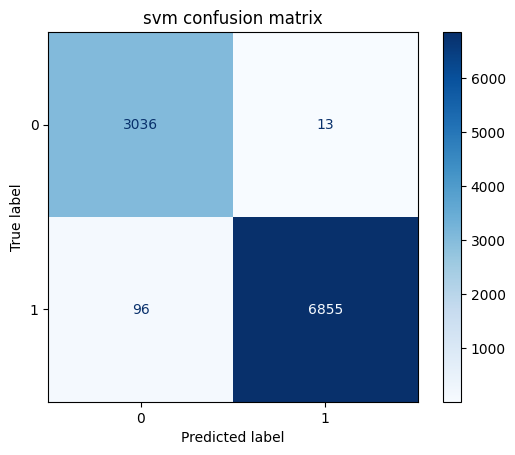

array([[3036,   13],
       [  96, 6855]])

In [36]:
cm = confusion_matrix(y_test_encoded, y_test_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("svm confusion matrix")
plt.show()
cm


the confusion matrix shows that the model correctly classified 3036 true positives from class one and only 13 false negatives from class one misclassified as class two also 96 false positives were misclassified as class one while 6855 true negatives from class two were correctly identified the errors are very few and the model is able to distinguish between the two classes effectively

In [21]:
model_2 = GaussianNB()
model_2.fit(x_train_processed, y_train_encoded)

y_train_pred_nb = model_2.predict(x_train_processed)
y_test_pred_nb = model_2.predict(x_test_processed)

train_acc_nb = accuracy_score(y_train_encoded, y_train_pred_nb)
train_prec_nb = precision_score(y_train_encoded, y_train_pred_nb, average='weighted', zero_division=0)
train_rec_nb = recall_score(y_train_encoded, y_train_pred_nb, average='weighted')
train_f1_nb = f1_score(y_train_encoded, y_train_pred_nb, average='weighted')

test_acc_nb = accuracy_score(y_test_encoded, y_test_pred_nb)
test_prec_nb = precision_score(y_test_encoded, y_test_pred_nb, average='weighted', zero_division=0)
test_rec_nb = recall_score(y_test_encoded, y_test_pred_nb, average='weighted')
test_f1_nb = f1_score(y_test_encoded, y_test_pred_nb, average='weighted')

print("\nnaive bayes results:")
print(f"train -> acc={train_acc_nb:.4f} prec={train_prec_nb:.4f} rec={train_rec_nb:.4f} f1={train_f1_nb:.4f}")
print(f"test  -> acc={test_acc_nb:.4f} prec={test_prec_nb:.4f} rec={test_rec_nb:.4f} f1={test_f1_nb:.4f}")



naive bayes results:
train -> acc=0.9955 prec=0.9955 rec=0.9955 f1=0.9955
test  -> acc=0.9957 prec=0.9957 rec=0.9957 f1=0.9957


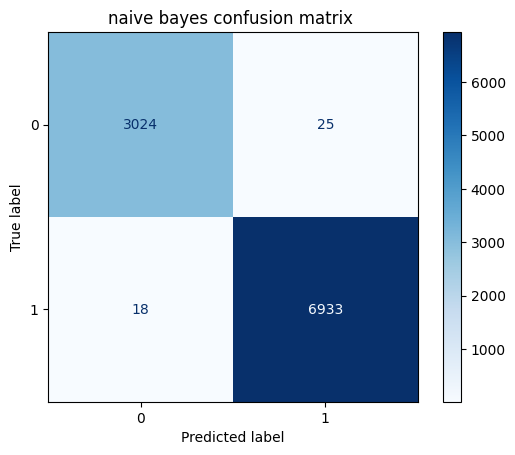

array([[3024,   25],
       [  18, 6933]])

In [22]:
cm = confusion_matrix(y_test_encoded, y_test_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("naive bayes confusion matrix ")
plt.show()
cm

The confusion matrix shows that the model correctly classified 3024 true positives from class one, with only 25 false negatives misclassified as class two. Additionally, there were 18 false positives misclassified as class one, while 6933 true negatives from class two were correctly identified. The number of errors is very low, and the model is able to distinguish between the two classes effectively. The SVM model performed better in identifying class one, while the Naive Bayes model showed better performance in classifying class two, but the difference between the two models is minimal

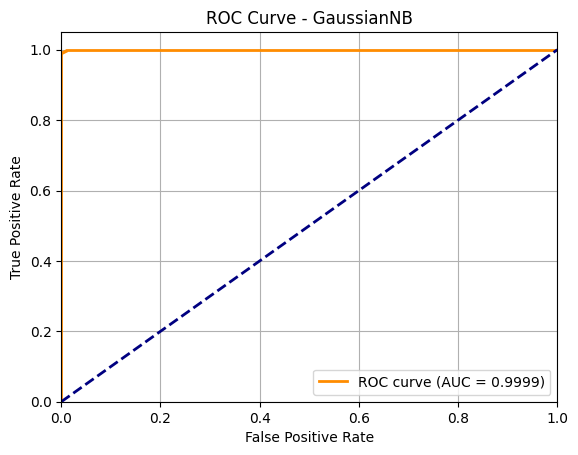

In [23]:
y_prob_nb = model_2.predict_proba(x_test_processed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob_nb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


the roc curve demonstrates the model strength by its steady upward trend without fluctuations and its clear separation from the random guess line

lets go to try ann

In [24]:
neural_network_model = Sequential([
    Dense(28, activation='relu', input_shape=(32,), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(28, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(28, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

neural_network_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = neural_network_model.fit(x_train_processed, y_train_encoded, validation_split=0.2, epochs=100, batch_size=64,callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6872 - loss: 0.6486 - val_accuracy: 0.9730 - val_loss: 0.1560
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9394 - loss: 0.2003 - val_accuracy: 0.9866 - val_loss: 0.0896
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9737 - loss: 0.1146 - val_accuracy: 0.9926 - val_loss: 0.0704
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0922 - val_accuracy: 0.9919 - val_loss: 0.0642
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9831 - loss: 0.0803 - val_accuracy: 0.9911 - val_loss: 0.0597
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9849 - loss: 0.0744 - val_accuracy: 0.9937 - val_loss: 0.0523
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9861 - loss: 0.0688 - val_accuracy: 0.9904 - val_loss: 0.0549
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9861 - loss: 0.0676 - val_accu

a neural network was built consisting of four layers each with 28 neurons using the relu activation function in the first three layers and sigmoid in the final layer since it is a binary classification task l2 regularization and dropout were used to reduce overfitting
the model was compiled using the adam optimizer to optimize the weights and binary crossentropy as the loss function with accuracy as the metric to evaluate performance during training and testing early stopping was used to stop the training once the best possible improvement was reached the model was then trained for 200 epochs with a batch size of 64 due to the large size of the data


In [25]:
y_pred_prob_ann = neural_network_model.predict(x_test_processed)

y_pred_class_ann = (y_pred_prob_ann > 0.5).astype("int32").flatten()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


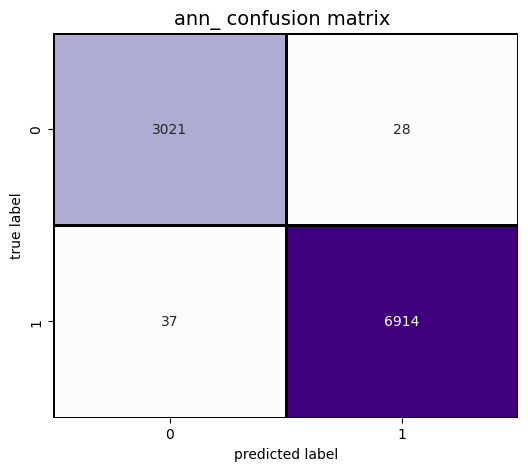

array([[3021,   28],
       [  37, 6914]])

In [26]:
cm = confusion_matrix(y_test_encoded, y_pred_class_ann)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False, linewidths=1, linecolor='black')
plt.title("ann_ confusion matrix ", fontsize=14)
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()
cm

The confusion matrix shows that the model correctly classified 3021 true positives from class one, with only 28 false negatives from class one misclassified as class two. Additionally, 37 false positives were misclassified as class one, while 6914 true negatives from class two were correctly identified. The number of errors is very low, and the model is able to distinguish between the two classes effectively, with better performance in class two indicated by fewer errors

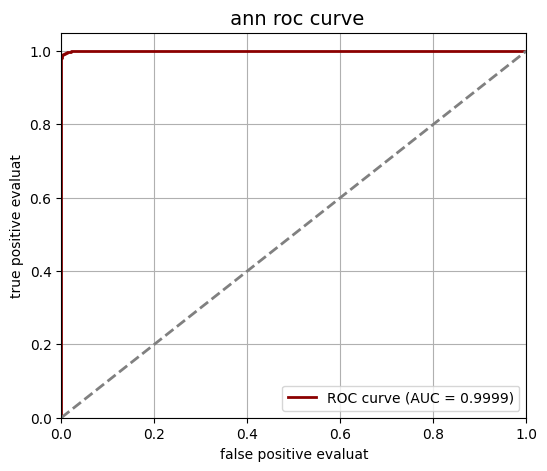

In [27]:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob_ann)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive evaluat')
plt.ylabel('true positive evaluat')
plt.title(' ann roc curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

the roc curve demonstrates the model strength by its steady upward trend without fluctuations and its clear separation from the random guess line

In [28]:
pipeline_nb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GaussianNB())
])

pipeline_nb.fit(x_train, y_train)
print(f"test accuracy: {pipeline_nb.score(x_test, y_test):.4f}")

test accuracy: 0.9957


a pipeline was built to include the preprocessing steps and the model for later use

In [29]:
results = {
    'Model': ['SVM', 'naive bayes', 'Ann neural_network'],
    'accuracy': [0.9891, 0.9957, 0.9934]}
df_results = pd.DataFrame(results)
print(df_results)

                Model  accuracy
0                 SVM    0.9891
1         naive bayes    0.9957
2  Ann neural_network    0.9934


the accuracy comparison of the models on the test data shows no significant differences all models generalize wel

In [30]:
cv= StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(pipeline_nb,x_train,y_train,cv=cv,scoring='accuracy')
print('cv scores_train:',scores)
print('std cv score_rain:',scores.std())
print("average cv accuracy_train:", scores.mean())
print("-" * 50)
pipeline_nb.fit(x_train, y_train)
y_pred = pipeline_nb.predict(x_test)
metrics = {}
for label in ['Low', 'High']:
    precision = precision_score(y_test, y_pred, pos_label=label)
    recall = recall_score(y_test, y_pred, pos_label=label)
    f1 = f1_score(y_test, y_pred, pos_label=label)
    metrics[label] = {'precision': precision,'recall': recall, 'f1 Score': f1}

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy:.4f}")
for label, scores in metrics.items():
    print(f"class: {label}")
    print(f" precision: {scores['precision']:.4f}")
    print(f" recall   : {scores['recall']:.4f}")
    print(f" f1 Score : {scores['f1 Score']:.4f}")

cv scores_train: [0.995125 0.994625 0.992625 0.993375 0.99575 ]
std cv score_rain: 0.0011445523142259747
average cv accuracy_train: 0.9943
--------------------------------------------------
accuracy: 0.9957
class: Low
 precision: 0.9964
 recall   : 0.9974
 f1 Score : 0.9969
class: High
 precision: 0.9941
 recall   : 0.9918
 f1 Score : 0.9929


the model achieved a high test accuracy of 99.57 percent which aligns closely with the cross validation average of 99.43 percent indicating strong generalization performance
precision recall and f1 scores for both classes low and high are all above 99 percent showing that the model is well balanced and performs consistently across both categories despite the class imbalance 70 to 30
this suggests the model is neither overfitting nor biased towards the majority class

In [31]:
feature_names = preprocessor.get_feature_names_out()
clean_feature_names = [name.replace('minmax__', '').replace('onehot__', '') for name in feature_names]
perm_importance = permutation_importance( model_2,x_test_processed,y_test_encoded,n_repeats=10,random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=clean_feature_names)
feature_importance = feature_importance.sort_values(ascending=False)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
feature_importance

,0
Sales_Volume,0.418800
Region_Europe,0.000460
Region_North America,0.000350
Model_3 Series,0.000300
Model_X1,0.000300
Price_USD,0.000290
Model_i3,0.000280
Model_X3,0.000250
Model_i8,0.000210
Mileage_KM,0.000200


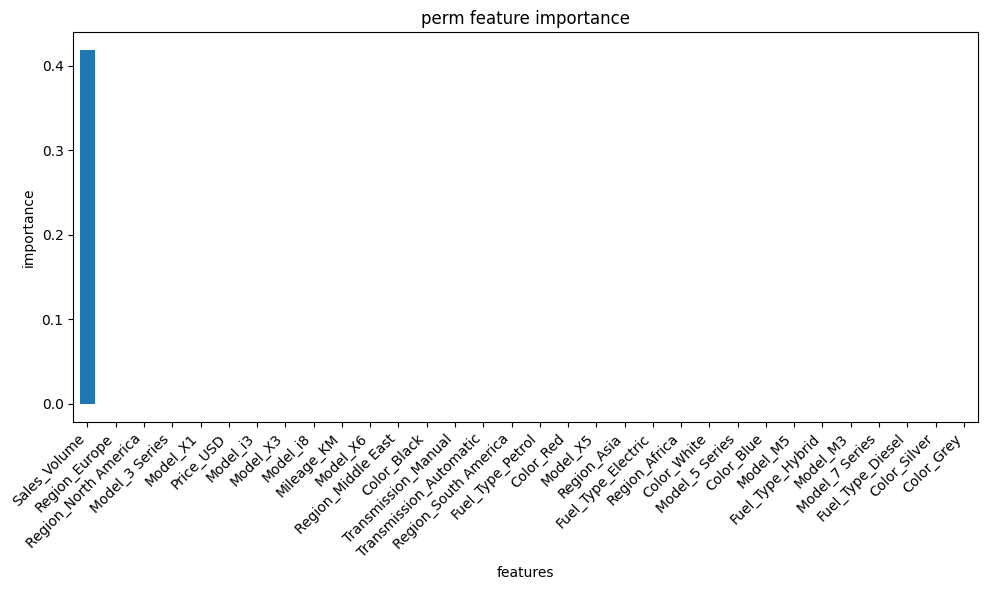

In [32]:
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('perm feature importance')
plt.xlabel('features')
plt.ylabel('importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(pipeline_nb, "nb_pipeline.pkl")

['nb_pipeline.pkl']

the final result shows that the models performed strongly with close and consistent results and no signs of overfitting the sales volume column had the most significant influence on the decision

currently based on the available data the naive bayes model provides good performance in terms of accuracy and training speed it also handles the data size reasonably well which is not considered very small the performance difference compared to other models is negligible however in the future with the potential increase in the number of features a neural network model is expected to perform better**
